In [1]:
from os import listdir
from os.path import isfile, join
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from json import loads
from re import findall,UNICODE
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

use_cache = True

In [2]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

In [4]:
q = Book.objects.filter(exclude=False,
                        length__gt=10000,
                        length__lte=200000,
                        downloads__gte=150,
                        numUniqWords__gt=1000,
                        numUniqWords__lt=18000,
                        lang_code_id=0)

In [5]:
version = "006"
salad = True
salad_string = "-salad" # -salad
salad_dir = "/salad" # /salad
if isfile("data/gutenberg/timeseries{0}-matrix-cache-{1}.p".format(salad_string,version)) and use_cache:
    big_matrix = pickle.load(open("data/gutenberg/timeseries{0}-matrix-cache-{1}.p".format(salad_string,version),"rb"))
else:
    # load all of the timeseries into a matrix
    big_matrix = np.ones([len(q),200])
    # big_matrix_mean0 = np.ones(big_matrix.shape)
    stop_val = 1.0
    for i,b in enumerate(q):
        if i%100 == 0:
            print(i)
        # print(b.title)
        b_data = Book_raw_data(b)
        a = b_data.chopper_sliding(my_LabMT,num_points=200,stop_val=stop_val,randomize=salad)
        big_matrix[i,:] = b_data.timeseries
    print(big_matrix.shape)
    pickle.dump(big_matrix,open("data/gutenberg/timeseries{0}-matrix-cache-{1}.p".format(salad_string,version),"wb"),pickle.HIGHEST_PROTOCOL)
    
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()
big_matrix_start0 = big_matrix-np.tile(big_matrix[:,0],(200,1)).transpose()
print(big_matrix.shape)

(1729, 200)


In [6]:
# pre compute the full distance matrix
# ouch

# the city block distance betwen two vectors
def cityBlock(a,b):
    return np.sum(np.abs(a-b))

# define a quick cache for this one...
if isfile("data/gutenberg/pairwise-distance-matrix-cache{}-{}.p".format(salad_string,version)) and use_cache:
    allDistances = pickle.load(open("data/gutenberg/pairwise-distance-matrix-cache{}-{}.p".format(salad_string,version),"rb"))
    allDistancesCentered = pickle.load(open("data/gutenberg/pairwise-distance-mean0-matrix-cache{}-{}.p".format(salad_string,version),"rb"))
    allDistancesStart = pickle.load(open("data/gutenberg/pairwise-distance-start0-matrix-cache{}-{}.p".format(salad_string,version),"rb"))
else:
    pairWiseDistances = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    pairWiseDistancesCentered = np.zeros([big_matrix_mean0.shape[0],big_matrix_mean0.shape[0]])
    pairWiseDistancesStart = np.zeros([big_matrix_start0.shape[0],big_matrix_start0.shape[0]])
    for i in range(big_matrix.shape[0]):
        if i%100 == 0:
            print(i)
        # compute only the upper diagonal
        for j in range(i,big_matrix.shape[0]):
            pairWiseDistances[i,j] = cityBlock(big_matrix[i,:],big_matrix[j,:])
            pairWiseDistancesCentered[i,j] = cityBlock(big_matrix_mean0[i,:],big_matrix_mean0[j,:])
            pairWiseDistancesStart[i,j] = cityBlock(big_matrix_start0[i,:],big_matrix_start0[j,:])
    # build the full matrices
    allDistances = pairWiseDistances+np.transpose(pairWiseDistances)
    allDistancesCentered = pairWiseDistancesCentered+np.transpose(pairWiseDistancesCentered)
    allDistancesStart = pairWiseDistancesStart+np.transpose(pairWiseDistancesStart)
    pickle.dump(allDistances,open("data/gutenberg/pairwise-distance-matrix-cache{}-{}.p".format(salad_string,version),"wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesCentered,open("data/gutenberg/pairwise-distance-mean0-matrix-cache{}-{}.p".format(salad_string,version),"wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesStart,open("data/gutenberg/pairwise-distance-start0-matrix-cache{}-{}.p".format(salad_string,version),"wb"),pickle.HIGHEST_PROTOCOL)

In [7]:
# metric = "cityblock"
# # go to two clusters on the top
# n_clusters = 2

# model = AgglomerativeClustering(n_clusters=n_clusters,
#                                 linkage="average",
#                                 affinity=metric,
#                                 compute_full_tree=True)

# # using the scipy implementation instead
# model.fit(big_matrix)

# print(model.labels_)
# print(model.labels_.size)

# print(model.n_leaves_)
# print(model.children_)
# children = np.array(model.children_,dtype=np.float64)

In [8]:
# # this seems okay, but city block is not what I want here (that was
# # already used for dimension reduction)
# method = 'average'
# metric = 'cityblock'

# this will generate more uniform clusters
method = 'ward'
metric = 'euclidean'

from scipy.cluster.hierarchy import dendrogram,linkage
fit = linkage(allDistances,metric=metric,method=method)
fit2 = linkage(allDistancesCentered,metric=metric,method=method)
fit3 = linkage(allDistancesStart,metric=metric,method=method)

In [9]:
# let's try to understand this matrix fit
# A 4 by (n-1) matrix Z is returned.
print(allDistances.shape)
print(fit.shape)
print("this is (n-1) by 4, as expected")
print("-"*20)

# At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] 
# are combined to form cluster n + i.
print("...so at iteration n+i, fit[-1,:] we find:")
print(fit[-1,:])
print("-"*20)
# old indices:
# this means clusters 6152 and 6153 were combined to form cluster 3077+3077=6154
# new indices?
# this means clusters fit[-1,0] and fit[-1,1] were combined to form cluster 1755+1755=3510

# A cluster with an index less than n corresponds to one of the original observations.
#...so cluster 0, cluster 3000 are the books at 0, and 3000, themselves

# The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2].
# ...so the distance between clusters 6152 and 6153 is 72466

# The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
# ...and, we now have all of the books in that cluster

print(fit[0,:])
print(fit[1,:])
print("...")
print(fit[-2,:])
print(fit[-1,:])

(1729, 1729)
(1728, 4)
this is (n-1) by 4, as expected
--------------------
...so at iteration n+i, fit[-1,:] we find:
[  3453.           3455.          30670.44282169   1729.        ]
--------------------
[  770.          1455.             4.20738202     2.        ]
[  920.          1269.             4.42523246     2.        ]
...
[  3452.           3454.          27656.44315725   1308.        ]
[  3453.           3455.          30670.44282169   1729.        ]


In [10]:
# define a threshold
threshold = 70000
# and we'll go get all of the clusters that are merged under that threshold
# ...this has the effect of slicing the dendrogram at any height

# a dangerously recursive function
def get_children():
    c = []
    if not True:
        get_children()
    return c

def get_cluster_indices(model,threshold=70000,return_cluster_names=False):
    cluster_list = np.array([i for i in range(allDistances.shape[0])])
    for i,merge in enumerate(model):
        if merge[2] < threshold:
            # print(merge)
            # print(int(merge[0]))
            a = cluster_list==int(merge[0])
            cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
            cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
    # print(cluster_list[:10])
    # print(cluster_list[1730:1740])
    clusters = np.unique(cluster_list)
    a = np.arange(allDistances.shape[0])
    indices = [a[cluster_list==c] for c in clusters]
    num_clusters = len(indices)
    cluster_sizes = list(map(len,indices))
    # print('found {0} clusters of sizes:'.format(num_clusters))
    # print(cluster_sizes)
    if return_cluster_names:
        return indices,num_clusters,cluster_sizes,cluster_list
    else:
        return indices,num_clusters,cluster_sizes
    
def get_cluster_indices_from_id(model,cluster_id):
    if cluster_id < allDistances.shape[0]:
        return np.array([cluster_id])
    cluster_list = np.array([i for i in range(allDistances.shape[0])])
    for i,merge in enumerate(model):
        if merge[2] <= model[cluster_id-allDistances.shape[0]+1,2]:
            # print(merge)
            # print(int(merge[0]))
            a = cluster_list==int(merge[0])
            cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
            cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
    a = np.arange(allDistances.shape[0])
    # print(cluster_list)
    indices = a[cluster_list==cluster_id]
    return indices

ind,nc,cs = get_cluster_indices(fit,threshold=70000)
ind,nc,cs = get_cluster_indices(fit,threshold=40000)
ind,nc,cs = get_cluster_indices(fit,threshold=25000)
ind,nc,cs = get_cluster_indices(fit,threshold=20000)
ind,nc,cs,cluster_list = get_cluster_indices(fit,threshold=5000,return_cluster_names=True)
print('checking the new function')
print(cluster_list)
print(cluster_list==cluster_list[0])
# print(ind[0])
ind = get_cluster_indices_from_id(fit,cluster_list[0])
print(ind)
print(len(ind))
ind,nc,cs = get_cluster_indices(fit2,threshold=25000)
ind,nc,cs = get_cluster_indices(fit2,threshold=11000)
ind,nc,cs = get_cluster_indices(fit2,threshold=5000)
ind,nc,cs = get_cluster_indices(fit2,threshold=2000)

checking the new function
[3435 3445 3435 ..., 3443 3445 3446]
[ True False  True ..., False False False]
[   0    2   15   24   40   45   61   63   71   77   80   86   87   97   98
  120  123  128  135  141  143  147  150  152  159  160  162  166  170  182
  193  208  213  215  219  228  233  240  242  244  245  252  259  269  275
  276  282  283  284  287  297  304  305  308  309  312  350  352  375  376
  394  397  415  424  430  432  450  452  453  458  461  462  477  478  484
  490  491  498  504  520  524  529  538  544  548  557  574  579  594  595
  597  602  618  620  625  627  630  634  639  640  641  642  646  674  683
  694  701  719  730  738  743  751  754  767  780  789  790  793  794  797
  798  808  809  817  819  821  822  823  837  840  841  845  848  857  862
  867  868  896  911  921  924  929  952  959 1004 1009 1019 1045 1049 1055
 1057 1065 1083 1088 1095 1102 1103 1105 1112 1134 1152 1155 1173 1174 1180
 1188 1215 1231 1232 1234 1235 1240 1251 1279 1289 1301 13

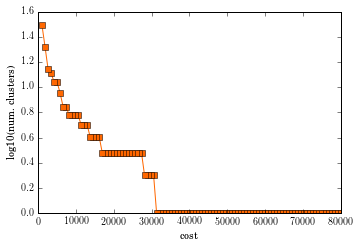

In [11]:
x = np.linspace(80000,1000,num=100)
y = np.zeros([100,1])
for i,cost in enumerate(x):
    ind,nc,cs = get_cluster_indices(fit,threshold=cost)
    y[i] = nc
fig = plt.figure()
ax = fig.add_axes([.2,.2,.7,.7])
ax.plot(x,np.log10(y),'s-',color='#ff6700')
ax.set_ylabel('log10(num. clusters)')
ax.set_xlabel('cost')
# mysavefig('heirarchal-clustering-cost.svg')

In [12]:
R = dendrogram(fit,distance_sort='ascending',no_plot=True,truncate_mode='lastp')

In [13]:
# R = dendrogram(fit,distance_sort='ascending')

In [14]:
ind,nc,cs,cluster_list = get_cluster_indices(fit3,threshold=655,return_cluster_names=True)

In [15]:
leaves = R['leaves']
print('leaves:')
print(leaves[:10])

leaves:
[3408, 3424, 3417, 3420, 3423, 3394, 3404, 3419, 3391, 3412]


In [16]:
indices_sorted = [get_cluster_indices_from_id(fit,leaf) for leaf in R['leaves']]

In [17]:
print(indices_sorted[:10])

[array([  18,  151,  174,  202,  207,  250,  318,  366,  382,  392,  416,
        446,  465,  469,  547,  558,  572,  573,  616,  647,  681,  692,
        725,  748,  752,  772,  810,  812,  815,  860,  922,  942,  980,
        982, 1017, 1030, 1039, 1058, 1061, 1096, 1135, 1139, 1160, 1161,
       1197, 1204, 1210, 1228, 1233, 1247, 1263, 1275, 1277, 1297, 1313,
       1332, 1350, 1427, 1446, 1447, 1448, 1452, 1453, 1462, 1471, 1492,
       1500, 1547, 1562, 1568, 1601, 1604, 1620, 1650, 1668, 1677, 1685,
       1700, 1703]), array([  28,  125,  129,  167,  168,  173,  241,  338,  364,  378,  443,
        460,  515,  550,  553,  562,  586,  599,  605,  662,  711,  715,
        729,  737,  802,  804,  830,  834,  835,  859,  861,  888,  902,
        905,  944,  945,  947,  949,  973,  998, 1010, 1022, 1033, 1037,
       1047, 1073, 1090, 1092, 1093, 1107, 1115, 1118, 1131, 1170, 1194,
       1283, 1311, 1351, 1403, 1434, 1435, 1438, 1464, 1473, 1494, 1514,
       1515, 1535, 1543, 1566

In [18]:
len(indices_sorted)

30

In [19]:
# but hey, some of them are empty!!

(1728, 4)
4.20738201911
30670.4428217


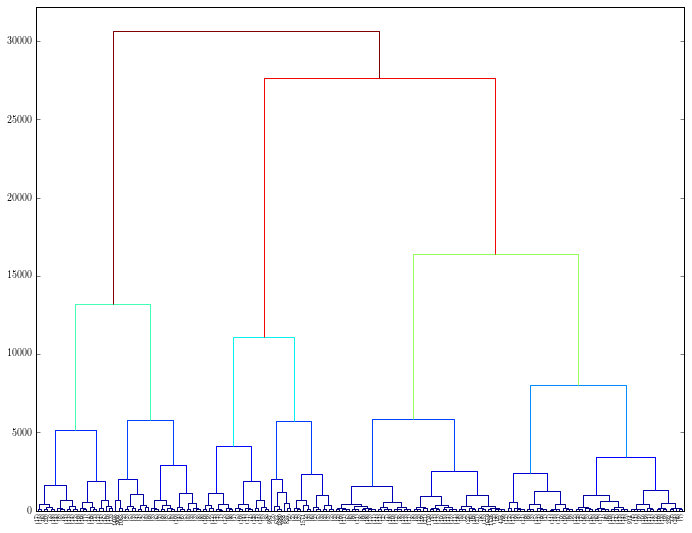

In [20]:
figsize=10
p=200
fig = plt.figure(figsize=(figsize,figsize))
ax = fig.add_axes([0.1,0.3,0.9,0.7])
colors = ['k' for i in range(fit.shape[0]*2)]

alltitles = [q[i].title for i in range(len(q))]

print(fit.shape)

cm = plt.get_cmap('jet')
print(fit[0,2])
print(fit[-1,2])

from matplotlib.colors import rgb2hex

def printcolor(k,yes='yes'):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return rgb2hex(cm(fit[k-fit.shape[0]-1,2]/fit[-1,2]))

def llf(k):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return alltitles[k-fit.shape[0]-1]

R = dendrogram(fit,
               p=p,
               truncate_mode='lastp',
               link_color_func=lambda k: printcolor(k,yes='n'),
               ax=ax,
               # leaf_rotation=0.,
               # labels=alltitles,
               # leaf_label_func=llf,
               # leaf_label_func=lambda k: q[k].title,
               # orientation='right',
               orientation='top',
               # no_labels=True,
               )

# # ax.set_yscale('log')
# # ax.set_ylim([5,fit[-1,2]])
# tmp = ax.xaxis.get_ticklabels()
# # print(tmp)

# # ind,nc,cs,cluster_list = get_cluster_indices(fit,threshold=655,return_cluster_names=True)
# # index_index = [np.where(np.unique(cluster_list)==leaves[i]) for i in range(200)]
# # indices_sorted = [ind[index_index[i]] for i in range(200)]
# # titles_sorted = [alltitles[ind[0]] for ind in indices_sorted]
# tmp2 = ax.get_xticks()
# ax.set_xticks(ax.get_xticks())
# # tmp3 = ax.set_xticklabels(ax.get_xticks(),justtitles, ha='right', rotation=-80)
# # tmp4 = plt.xticks(ax.get_xticks(),justtitles, ha='left', rotation=-80)
# # mysavefig('dendrogram-{0}x{0}-truncatelastp-p{1}.svg'.format(figsize,p))

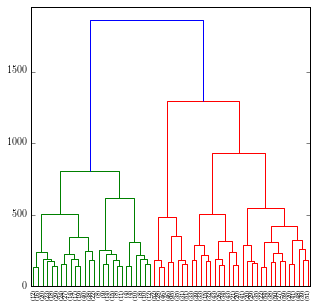

In [21]:
figsize=5
p=60
plt.figure(figsize=(figsize,figsize))
R = dendrogram(fit2,p=p,truncate_mode='lastp')
# mysavefig('dendrogram-{0}x{0}-truncatelastp-p{1}-centered.svg'.format(figsize,p))

In [22]:
now = datetime.now()
sorted_fname_now = now.strftime("data/gutenberg/%Y-%m-%d-%H-%M-pairwise-distance-matrix-sorted-cache{}-{}.p".format(salad_string,version))
sorted_fname = "data/gutenberg/pairwise-distance-matrix-sorted-cache{}-{}.p".format(salad_string,version)
if isfile(sorted_fname) and use_cache:
    print("loading from file")
    allDistancesSorted = pickle.load(open(sorted_fname,"rb"))
else:
    print("remaking")
    R = dendrogram(fit2,distance_sort='ascending',no_plot=True)
    leaveList = np.array(R['leaves'])
    allDistancesSorted = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    for i in range(big_matrix.shape[0]):
        # print(i)
        # compute only the upper diagonal
        # for j in range(big_matrix.shape[0]):
        #    allDistancesSorted[i,j] = cityBlock(big_matrix[leaveList[i],:],big_matrix[leaveList[j],:])
        allDistancesSorted[i,:] = allDistancesCentered[i,leaveList]
    allDistancesSorted = allDistancesSorted[leaveList,:]
    pickle.dump(allDistancesSorted,open(sorted_fname,"wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesSorted,open(sorted_fname_now,"wb"),pickle.HIGHEST_PROTOCOL)

loading from file


19.7317443842


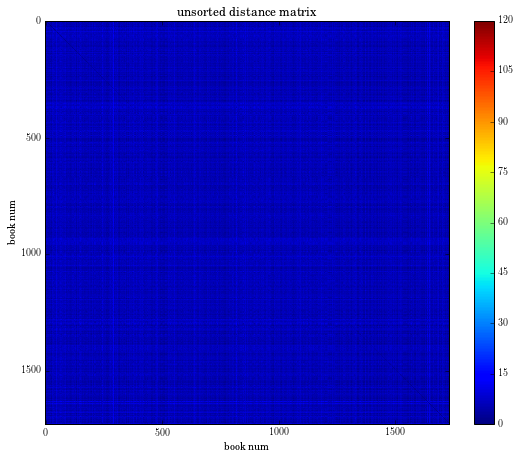

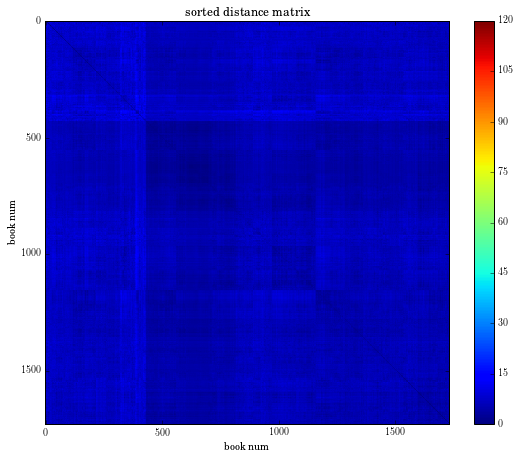

In [23]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
# screw memory...I have a SSD!

print(allDistancesCentered.max())

cax = plt.imshow(allDistancesCentered)
# ax1.colorbar()
plt.colorbar(cax,ax=ax1,shrink=0.8)
plt.clim([0,120])
ax1.set_title('unsorted distance matrix')
ax1.set_xlabel('book num')
ax1.set_ylabel('book num')
# plt.colorbar?
# mysavefig('unsorted-distance-matrix.png')
# mysavefig('unsorted-distance-matrix.svg')

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
# ax1 = plt.subplot(1,2,2)
cax = plt.imshow(allDistancesSorted)
# ax1.colorbar()
plt.colorbar(cax,ax=ax1,shrink=0.8)
plt.clim([0,120])
ax1.set_title('sorted distance matrix')
ax1.set_xlabel('book num')
ax1.set_ylabel('book num')
# plt.colorbar?
# mysavefig('sorted-distance-matrix.png')
# mysavefig('sorted-distance-matrix.svg')

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1726 1726 1726 ..., 1726 1726 1726]
 [1727 1727 1727 ..., 1727 1727 1727]
 [1728 1728 1728 ..., 1728 1728 1728]]


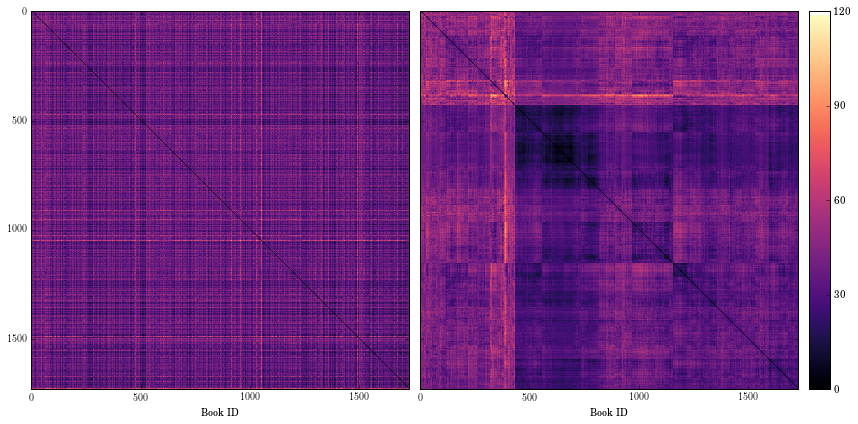

In [24]:
cap = 50

fig = plt.figure(figsize=(15,7.5))
ax1 = fig.add_axes([0.15,0.2,0.35,0.7])
# screw memory...I have a SSD!
# plt.subplot(1,2,1)
allDistances_capped = allDistancesCentered.copy()
allDistances_capped[allDistancesCentered > cap] = cap
ax1.imshow(allDistances_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax1.set_xlabel('Book ID')
# plt.ylabel('book num')

allDistancesSorted_capped = allDistancesSorted.copy()
allDistancesSorted_capped[allDistancesSorted > cap] = cap
ax2 = fig.add_axes([0.51,0.2,0.35,0.7])
ax2.imshow(allDistancesSorted_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax2.set_xlabel('Book ID')
ax2.set_yticklabels([])

ax3 = fig.add_axes([0.86,0.2,0.04,0.7])
my_cmap = np.tile(np.arange(allDistancesSorted.shape[0]),(100,1)).transpose()
print(my_cmap)
ax3.imshow(my_cmap,cmap=plt.get_cmap("magma"),origin="lower")
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.yaxis.tick_right()
ax3.set_yticks([0,1752*.25,1752*.5,1752*.75,1752])
ax3.set_yticklabels(map(int,[0,120*.25,120*.5,120*.75,120]))

mysavefig("clustered-matrix-2-{}.pdf".format(cap),openfig=True,date=True,folder="media/figures/clustering{}".format(salad_dir))

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1726 1726 1726 ..., 1726 1726 1726]
 [1727 1727 1727 ..., 1727 1727 1727]
 [1728 1728 1728 ..., 1728 1728 1728]]


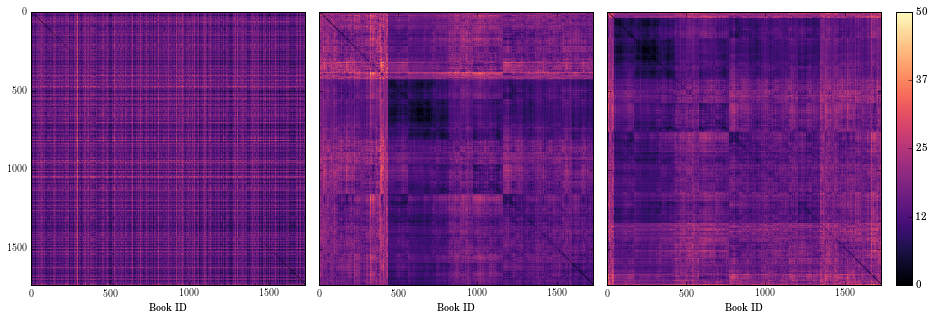

In [25]:
cap = 50
numel = len(q)-1

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes([0.15,0.15,0.8/3,0.8-.04])
# screw memory...I have a SSD!
# plt.subplot(1,2,1)
allDistances_capped = allDistancesCentered.copy()
allDistances_capped[allDistancesCentered > cap] = cap
ax1.imshow(allDistances_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax1.set_xlabel('Book ID')
# plt.ylabel('book num')

allDistancesSorted_capped = allDistancesSorted.copy()
allDistancesSorted_capped[allDistancesSorted > cap] = cap
ax2 = fig.add_axes([0.15+0.8/3,0.15,0.8/3,0.8-.04])
ax2.imshow(allDistancesSorted_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax2.set_xlabel('Book ID')
ax2.set_yticklabels([])

# go and find the shift! put the story with the greatest distance between neighbors in the
# upper left
shift = list(map(lambda x: x%len(q),np.arange(allDistancesSorted.shape[0])+np.argmax(allDistancesSorted.sum(axis=1))))
ax3 = fig.add_axes([0.15+0.8/3+0.8/3,0.15,0.8/3,0.8-.04])
ax3.imshow(allDistancesSorted_capped[shift,:][:,shift],cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax3.set_xlabel('Book ID')
ax3.set_yticklabels([])

ax4 = fig.add_axes([0.15+0.8/3+0.8/3+0.8/3,0.15,0.03,0.8-.04])
my_cmap = np.tile(np.arange(allDistancesSorted.shape[0]),(100,1)).transpose()
print(my_cmap)
ax4.imshow(my_cmap,cmap=plt.get_cmap("magma"),origin="lower")
ax4.set_xticks([])
ax4.set_xticklabels([])
ax4.yaxis.tick_right()
ax4.set_yticks([0,numel*.25,numel*.5,numel*.75,numel])
ax4.set_yticklabels(map(int,[0,cap*.25,cap*.5,cap*.75,cap]))

mysavefig("clustered-matrix-3-{}.pdf".format(cap),openfig=True,date=True,folder="media/figures/clustering{}".format(salad_dir))

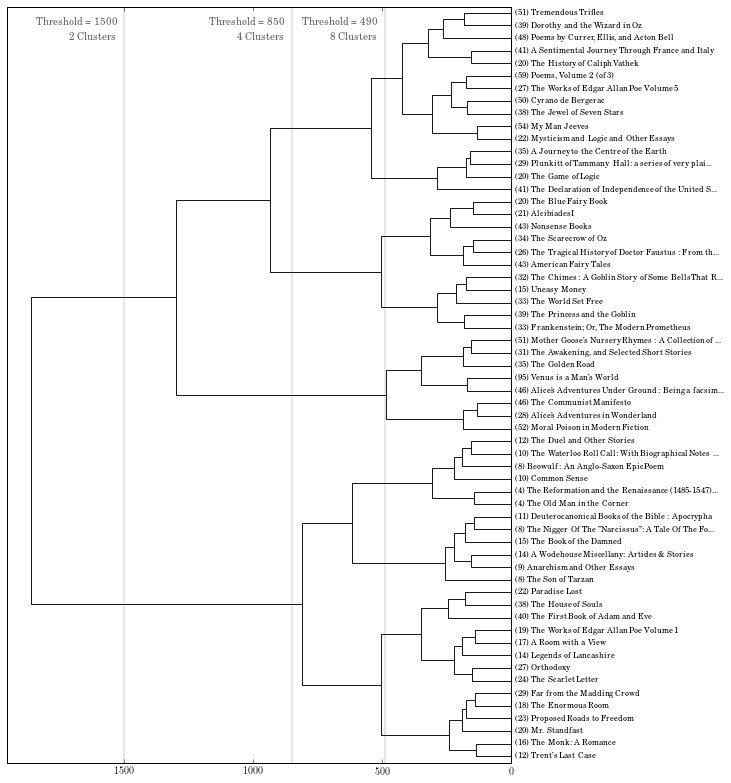

In [26]:
from matplotlib.colors import rgb2hex

def printcolor(k,yes='yes',fit=fit2):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return rgb2hex(cm(fit[k-fit2.shape[0]-1,2]/fit[-1,2]))

def llf(k):
    chars = 50
    all_ind = get_cluster_indices_from_id(fit2,k)
#     print(k,all_ind)
    # go get the submatrix
    # allDistances[[1,2,3],:][:,[1,2,3]]
    submat = allDistances[all_ind,:][:,all_ind]
#     print(submat)
    distances = submat.sum(axis=0)
#     print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
#     print(all_ind_sorted)
#     print(all_ind_sorted[0])
    if len(all_ind_sorted) == 0:
        print("no book found?")
        print(k)
    b = q[int(all_ind_sorted[0])]
    # b = q[627]
    if len(b.title) > chars:
        s = "({}) {}...".format(len(all_ind),b.title[:chars-3].replace("\n",": ").replace("&","\&"))
    else:
        s = "({}) {}".format(len(all_ind),b.title.replace("\n",": ").replace("&","\&"))
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    s = s.encode("ascii","ignore").decode("ascii")
    return s
    

# R = dendrogram(fit,
#                p=p,
#                truncate_mode='lastp',
#                link_color_func=lambda k: printcolor(k,yes='n'),
#                ax=ax,
#                # leaf_rotation=0.,
#                # labels=alltitles,
#                # leaf_label_func=llf,
#                # leaf_label_func=lambda k: q[k].title,
#                # orientation='right',
#                orientation='top',
#                # no_labels=True,
#                )

p=60
fig = plt.figure(figsize=(10,15))
ax = fig.add_axes([.2,.2,.7,.7])
# ax.set_xscale('log',basex=10)
# ax.set_xlim([50,10000])
# ax.set_xlim(np.log10([50,10000]))
# colors = ["k" for i in range(p+1)]
R = dendrogram(fit2,
               p=p,
               link_color_func=lambda k: "0.1",
               truncate_mode="lastp",
               orientation="left",
               distance_sort="ascending",
               ax=ax,
               # leaf_label_func=lambda k: k-fit.shape[0]+1,
               leaf_label_func=llf,
               leaf_font_size=8,
               # link_color_func=lambda k: colors[k],
               # annotate_above=10000,
               )

y_range = ax.get_ylim()
def add_line(x,i):
    ax.plot([x,x],y_range,zorder=1,color=".9",linewidth=2)
    # example from mpl
#     bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2)
#     t = ax.text(0, 0, "Direction", ha="center", va="center", rotation=45,
#             size=15,
#             bbox=bbox_props)
    bbox_props = dict(boxstyle="square,pad=0.3", fc=".9", ec=".6", lw=1)
    ax.text(x+30,y_range[1]-8,"{}".format(i),color=".4",ha="right",va="top",linespacing=1.8,size=10) # ,bbox=bbox_props)
# thresholds = [29000,20000,11000,5500]
thresholds = [8000,3850,2050]
thresholds = [1500,850,490]
nc = [2,4,8]
for i,t in enumerate(thresholds):
    # add_line(t,i)
    add_line(t,"Threshold = {}\n{} Clusters".format(t,nc[i]))
# ax.set_xlim(np.log10([50,10000]))
# ax.set_xlim([400,11000])
mysavefig("dendrogram-left-p{}-topstories.pdf".format(p),openfig=True,date=True,folder="media/figures/clustering{}".format(salad_dir))

In [28]:
def get_cluster_indices2(model,threshold=70000):
    cluster_list = np.arange(allDistances.shape[0],dtype=int)
    # march through the model and cluster the stories as they are clustered in each step of model
    i = 0
    merge = model[i]
    while merge[2] < threshold:
        # print(merge)
        # print(int(merge[0]))
        a = cluster_list==int(merge[0])
        cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
        cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
        i+=1
        merge = model[i]
        
    # print(cluster_list[:10])
    # print(cluster_list[1730:1740])
    clusters = np.unique(cluster_list)
    a = np.arange(allDistances.shape[0],dtype=int)
    indices = [a[cluster_list==c] for c in clusters]
    # num_clusters = len(indices)
    # cluster_sizes = list(map(len,indices))
    # print('found {0} clusters of sizes:'.format(num_clusters))
    # print(cluster_sizes)
    return indices,cluster_list

def get_sorted(all_ind):
    # go get the submatrix
    # allDistances[[1,2,3],:][:,[1,2,3]]
    submat = allDistances[all_ind,:][:,all_ind]
    # print(submat)
    distances = submat.sum(axis=0)
    # print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
    distances_sorted = distances[indices_sorted]
    # print(all_ind_sorted)
    # make sure they're sorted the right way!
    # print(distances_sorted)
    # assert distances_sorted[0] < distances_sorted[1]
    titles_sorted = ["" for i in range(len(all_ind_sorted))]
    chars = 50
    for i,ind in enumerate(all_ind_sorted):
        b = q[int(ind)]
        if len(b.title) > chars:
            titles_sorted[i] = "{}. {}...".format(i+1,b.title[:chars-3].replace("\n",": "))
        else:
            titles_sorted[i] = "{}. {}".format(i+1,b.title.replace("\n",": "))
    return all_ind_sorted,titles_sorted
    
    
for i,t in enumerate(thresholds[:1]):
    # add_line(t,i)
    ind,cluster_list = get_cluster_indices2(fit,threshold=t)
    # ind,nc,cs = get_cluster_indices(fit,threshold=t)
    print(ind)
    # the indices...
    print(cluster_list)
    # for each story, which cluster it is in, by id (a reverse lookup of ind)
    ind_sorted,titles_sorted = get_sorted(ind[0])
    print(ind_sorted[:10])
    print(titles_sorted[:10])

[array([987]), array([  18,  151,  174,  202,  207,  250,  318,  366,  382,  392,  416,
        446,  465,  469,  547,  558,  572,  573,  616,  647,  681,  692,
        725,  748,  752,  772,  810,  812,  815,  860,  922,  942,  980,
        982, 1017, 1030, 1039, 1058, 1061, 1096, 1135, 1139, 1160, 1161,
       1197, 1204, 1210, 1228, 1233, 1247, 1263, 1275, 1277, 1297, 1313,
       1332, 1350, 1427, 1446, 1447, 1448, 1452, 1453, 1462, 1471, 1492,
       1500, 1547, 1562, 1568, 1601, 1604, 1620, 1650, 1668, 1677, 1685,
       1700, 1703]), array([  13,   46,  122,  155,  290,  302,  344,  370,  445,  448,  700,
        709,  818,  872,  917,  919,  935,  971,  974, 1050, 1053, 1097,
       1113, 1114, 1126, 1129, 1162, 1255, 1266, 1276, 1327, 1399, 1485,
       1533, 1536, 1537, 1557, 1564, 1591, 1639, 1641]), array([   0,    2,   45,   61,   63,   71,   77,   80,   86,   87,   97,
        120,  143,  147,  150,  159,  208,  213,  215,  233,  240,  259,
        275,  276,  282,  283, 

In [29]:
# now let's also plot them
def plot_clusters(clusters,data,v=True,fix_ylim=True,xspacing=.01,investigate=False,save=False,threshold=1000):
    # we are going to make plots of max width 3
    num_x = np.min([3,len(clusters)])
    num_y = np.ceil(len(clusters)/num_x)
    xspacing = .03
    yspacing = .03
    xoffset = .07
    yoffset = .07
    xwidth = (1.-xoffset)/(num_x)-xspacing
    yheight = (1.-yoffset)/(num_y)-yspacing
    print('xwidth is {0}'.format(xwidth))
    print('yheight is {0}'.format(yheight))
    
    # go compute the ybounds:
    calc_ylim = [100.0,-100.0]
    for cluster in clusters:
        c_max = data[cluster[0][:20],:].max()
        c_min = data[cluster[0][:20],:].min()
        calc_ylim[0] = np.min([calc_ylim[0],c_min])
        calc_ylim[1] = np.max([calc_ylim[1],c_max])
        
    chars = 60
    
    scale_factor_x = 5
    scale_factor_y = 5*1.25
    if investigate:
        scale_factor_x = 10
        scale_factor_y = 10*1.25
    fig = plt.figure(figsize=(scale_factor_x*num_x,scale_factor_y*num_y))
    for i,cluster in enumerate(clusters):
        print(i)
        print("====")
        # print((i-i%num_x))
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight))+yheight*.2,xwidth,yheight*.8]
        ax1 = fig.add_axes(ax1rect)
        ax1books_rect = ax1rect.copy()
        ax1books_rect[1] -= yheight*.2
        ax1books_rect[3] = yheight*.2
        ax1books = fig.add_axes(ax1books_rect)
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
            # print(cluster)
        j=0
        for index,title in zip(*cluster):
            if j+1 > 20:
                break
            if investigate:
                ax1.plot(data[index],label="{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id))
            else:
                ax1.plot(data[index],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(index,title)
            if j<5:
                ax1books.text(0.0,.8-j*.2,"{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id),fontsize=10)
            j+=1
        ax1.plot(data[cluster[0],:].mean(axis=0),color="#ff6700",linewidth=2,label="Threshold {} Cluster {} ({})".format(threshold,i+1,len(cluster[0])))
        # ax1.set_xticklabels([])
        ax1.legend(loc="upper right")

        # ax1.axis('off')
        ax1books.axis('off')
        
        props = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
        if fix_ylim:
            my_ylim = calc_ylim
        else:
            my_ylim = ax1.get_ylim()
        ax1.text(.035*200, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[i],
                     fontsize=14,
                     verticalalignment='top',
                     horizontalalignment='left',
                     bbox=props)

        if fix_ylim:
            ax1.set_ylim(calc_ylim)
        if fix_ylim and i%num_x > 0:
            ax1.set_yticklabels([])
        if True: # i<num_x*(num_y-1): # only on the bottom row
            ax1.set_xticklabels([])
            
    if save:
        # mysavefig('SV{0}.svg'.format('4-6'))
        mysavefig("clustered-timeseries-threshold-{}-num-{}.png".format(t,len(clusters)),
                  folder="media/figures/clustering{}".format(salad_dir),
                  openfig=False)
        mysavefig("clustered-timeseries-threshold-{}-num-{}.pdf".format(t,len(clusters)),
                  folder="media/figures/clustering{}".format(salad_dir),
                  openfig=True)

xwidth is 0.43499999999999994
yheight is 0.8999999999999999
0
====
1
====
xwidth is 0.28
yheight is 0.43499999999999994
0
====
1
====
2
====
3
====
xwidth is 0.28
yheight is 0.28
0
====
1
====
2
====
3
====
4
====
5
====
6
====
7
====
8
====


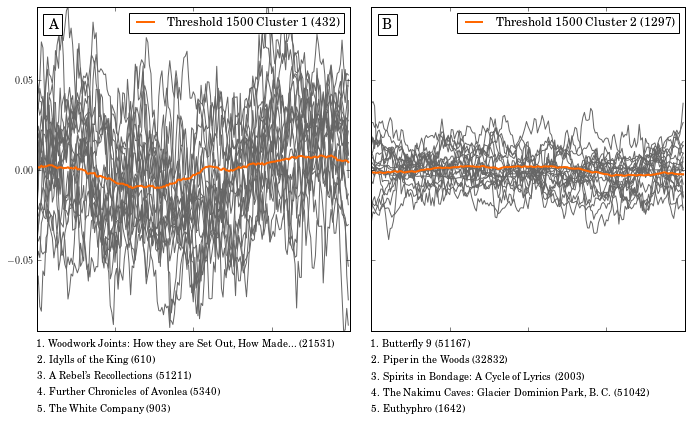

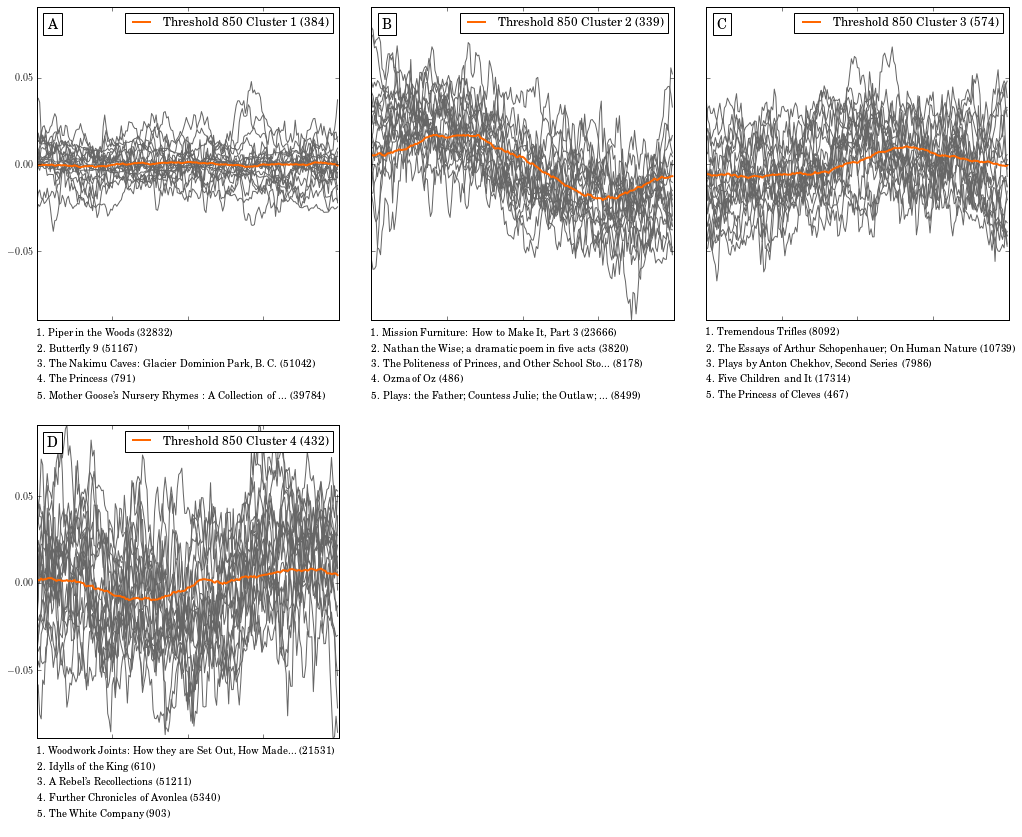

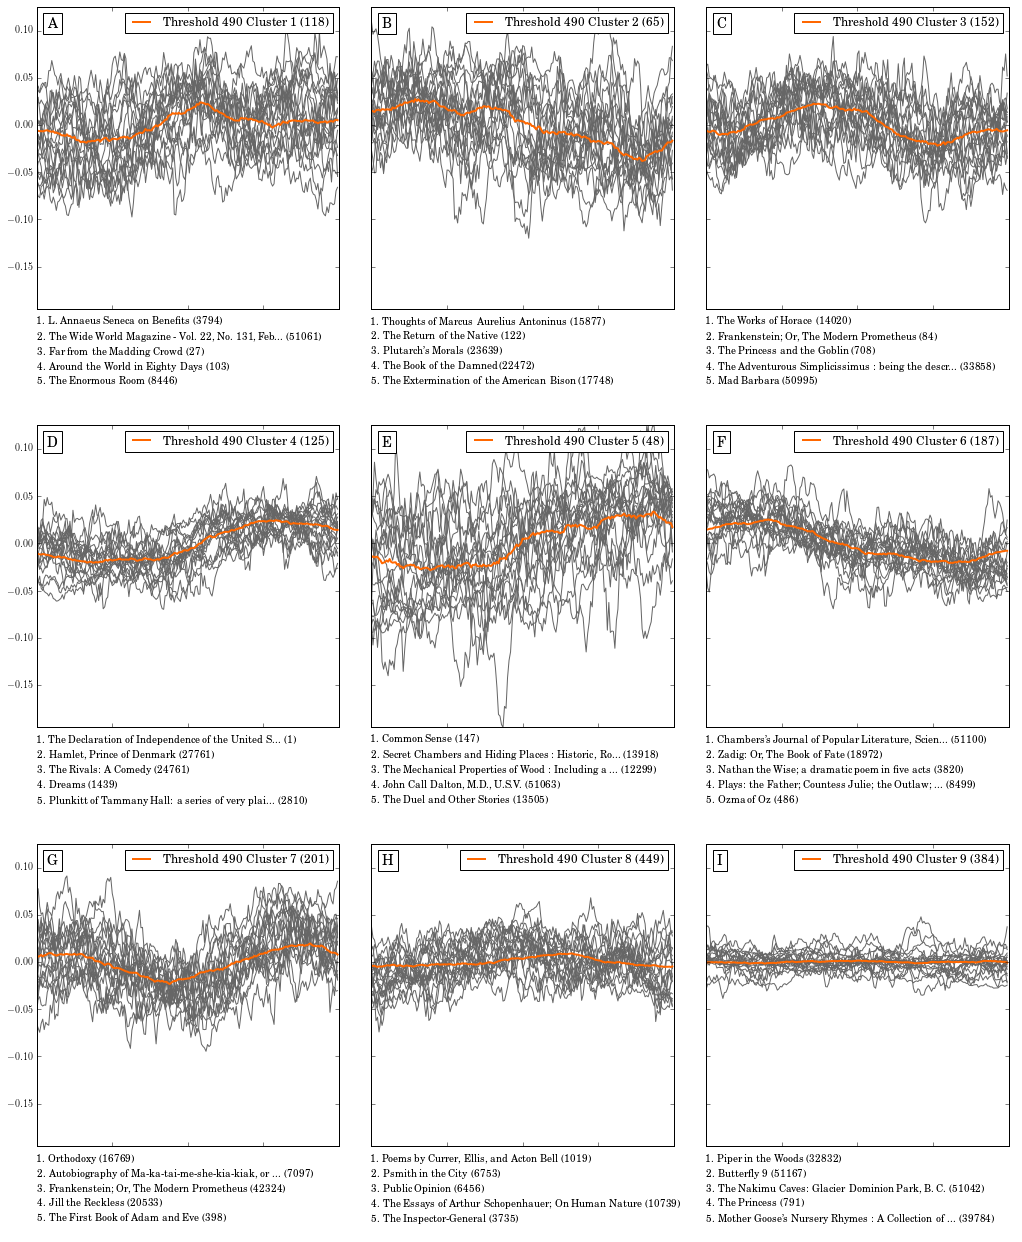

In [30]:
for i,t in enumerate(thresholds):
    # add_line(t,i)
    ind,cluster_list = get_cluster_indices2(fit2,threshold=t)
    # ind,nc,cs = get_cluster_indices(fit,threshold=t)
    # print(ind)
    # the indices...
    # print(cluster_list)
    # for each story, which cluster it is in, by id (a reverse lookup of ind)
    ind_sorted,titles_sorted = get_sorted(ind[0])
    # print(ind_sorted[:10])
    # print(titles_sorted[:10])
    
    # go and sort all of them
    ind_sorted_all = [get_sorted(i) for i in ind]
    # print(ind_sorted_all)
    
    # now let's try our new plotting function
    plot_clusters(ind_sorted_all,big_matrix_mean0,v=False,save=True,threshold=t) #,fix_ylim=[5.5,5.8])